In [3]:
import os
from pathlib import Path
import pandas as pd

# ── Paths ───────────────────────────────────────────────
IMG_DIR = Path(r"C:\Users\ahsan\Ahsan\Perigreen_paper\dataset\experiment1\classification")
CSV_RAW = Path(r"C:\Users\ahsan\Ahsan\Perigreen_paper\dataset\temporal_data.csv")

# 1. Load temporal data & drop first 5 rows
param_df = pd.read_csv(CSV_RAW).iloc[5:].reset_index(drop=True)
print(f"Rows after drop: {len(param_df)}")          # 1 814

# 2. Collect image paths + labels
image_paths, labels = [], []
for cls in ["0", "1"]:
    files = sorted(p for p in (IMG_DIR/cls).glob("*.png"))
    image_paths.extend(map(str, files))
    labels.extend([int(cls)] * len(files))

print(f"Total images found: {len(image_paths)}")    # 3 628

# 3. Duplicate parameter rows if counts match
if len(image_paths) == 2 * len(param_df):
    print("🔁 Duplicating param_df to match image count…")
    param_df = pd.concat([param_df, param_df], ignore_index=True)
else:
    raise ValueError("❌ Counts mismatch – check CSV or image folders.")

# 4. Save cleaned CSV
clean_csv = "param_df_cleaned.csv"
param_df.to_csv(clean_csv, index=False)
print(f"✅ Saved {len(param_df)} rows → {clean_csv}")


Rows after drop: 1814
Total images found: 3628
🔁 Duplicating param_df to match image count…
✅ Saved 3628 rows → param_df_cleaned.csv


In [4]:
# --- DefectDataset ---------------------------------------
import re
from pathlib import Path
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler

layer_re = re.compile(r"^(\d+)_")  # extract leading layer number

class DefectDataset(Dataset):
    """
    Multimodal dataset: (image, 20-dim process vector, label)
    Expects:
        image_dir/
            ├─ 0/*.png
            └─ 1/*.png
        csv_path : param_df_cleaned.csv  (3 628 rows; one per image)
    """
    def __init__(self, image_dir, csv_path,
                 transform=None, scaler=None, fit_scaler=False):
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        # 1) gather images, labels, layer numbers
        self.image_paths, self.labels, self.layers = [], [], []
        for cls in ["0", "1"]:
            for p in Path(image_dir, cls).glob("*.png"):
                self.image_paths.append(str(p))
                self.labels.append(int(cls))
                m = layer_re.match(p.name)
                if not m:
                    raise ValueError(f"Bad file name: {p.name}")
                self.layers.append(int(m.group(1)))

        # 2) load CLEAN csv (3 628 rows) and align by position
        df = pd.read_csv(csv_path).reset_index(drop=True)
        if len(df) != len(self.image_paths):
            raise ValueError("CSV rows ≠ images. Use cleaned file or fix dataset.")
        self.param_mat = df.iloc[self.layers].to_numpy(dtype="float32")

        # 3) scale parameters
        self.scaler = scaler or StandardScaler()
        if fit_scaler or scaler is None:
            self.scaler.fit(self.param_mat)
        self.param_mat = self.scaler.transform(self.param_mat)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        params = torch.tensor(self.param_mat[idx])
        label  = torch.tensor(self.labels[idx])
        return img, params, label


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

IMG_DIR = r"C:\Users\ahsan\Ahsan\Perigreen_paper\dataset\experiment1\classification"
CSV_CLEAN = "param_df_cleaned.csv"

# Load full dataset
full_ds = DefectDataset(IMG_DIR, CSV_CLEAN, fit_scaler=True)

# Step 1: Train-test split (20% test)
trainval_idx, test_idx = train_test_split(
    range(len(full_ds)),
    test_size=0.2,
    stratify=full_ds.labels,
    random_state=42
)

# Step 2: From remaining 80%, split 20% for validation → 64% train, 16% val, 20% test
train_idx, val_idx = train_test_split(
    trainval_idx,
    test_size=0.2,
    stratify=[full_ds.labels[i] for i in trainval_idx],
    random_state=42
)

# Create DataLoaders
train_loader = DataLoader(Subset(full_ds, train_idx), batch_size=32, shuffle=True)
val_loader   = DataLoader(Subset(full_ds, val_idx), batch_size=32, shuffle=False)
test_loader  = DataLoader(Subset(full_ds, test_idx), batch_size=32, shuffle=False)

print("Train batches:", len(train_loader),
      "| Validation batches:", len(val_loader),
      "| Test batches:", len(test_loader))


Train batches: 73 | Validation batches: 19 | Test batches: 23


In [6]:
import torch
import torch.nn as nn
from torchvision import models

class SmallVLM(nn.Module):
    """
    Multimodal model:
      • CNN (ResNet-18) on 224×224 RGB image  → 512-dim
      • MLP on tabular process parameters    → 32-dim
      • Concatenate → classify into 2 classes
    """
    def __init__(self, num_params: int):
        super().__init__()

        # Image branch: pretrained ResNet-18
        base = models.resnet18(weights="IMAGENET1K_V1")   # <- modern API
        base.fc = nn.Identity()       # remove final FC, output = 512
        self.cnn = base

        # Tabular branch
        self.mlp = nn.Sequential(
            nn.Linear(num_params, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # Fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, 2)          # 2 classes
        )

    def forward(self, img: torch.Tensor, params: torch.Tensor):
        img_feat = self.cnn(img)      # (B,512)
        tab_feat = self.mlp(params)   # (B,32)
        x = torch.cat((img_feat, tab_feat), dim=1)
        return self.classifier(x)     # (B,2 logits)


In [8]:
# ----------------------------------------------------------
# TRAIN / VALIDATION LOOP  (copy-paste ready)
# ----------------------------------------------------------
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = SmallVLM(num_params=full_ds.param_mat.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.set_grad_enabled(train):
        for img, vec, lbl in loader:
            img, vec, lbl = img.to(device), vec.to(device), lbl.to(device)

            out  = model(img, vec)
            loss = criterion(out, lbl)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * lbl.size(0)
            preds = out.argmax(1)
            correct += (preds == lbl).sum().item()
            total   += lbl.size(0)

    return total_loss / total, correct / total    # avg loss, accuracy

BEST_VAL = 0
EPOCHS   = 10

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader,  train=False)

    if val_acc > BEST_VAL:
        BEST_VAL = val_acc
        torch.save({"model_state": model.state_dict(),
                    "scaler": full_ds.scaler},
                   "small_vlm_defect.pt")

    print(f"[{epoch:02d}/{EPOCHS}]  "
          f"train {tr_loss:.4f}/{tr_acc:.3f} | "
          f"val {val_loss:.4f}/{val_acc:.3f} "
          f"{' <-- best' if val_acc==BEST_VAL else ''}")

print(f"✅ best validation accuracy: {BEST_VAL:.3f}")



[01/10]  train 0.0327/0.993 | val 0.0022/1.000  <-- best
[02/10]  train 0.0012/1.000 | val 0.0005/1.000  <-- best
[03/10]  train 0.0005/1.000 | val 0.0002/1.000  <-- best
[04/10]  train 0.0003/1.000 | val 0.0001/1.000  <-- best
[05/10]  train 0.0002/1.000 | val 0.0001/1.000  <-- best
[06/10]  train 0.0002/1.000 | val 0.0000/1.000  <-- best
[07/10]  train 0.0001/1.000 | val 0.0000/1.000  <-- best
[08/10]  train 0.0001/1.000 | val 0.0000/1.000  <-- best
[09/10]  train 0.0001/1.000 | val 0.0000/1.000  <-- best
[10/10]  train 0.0001/1.000 | val 0.0000/1.000  <-- best
✅ best validation accuracy: 1.000


In [9]:
torch.save({
    "model_state": model.state_dict(),
    "scaler": full_ds.scaler  # important for Streamlit
}, "small_vlm_defect.pt")
print("✅ Model saved as small_vlm_defect.pt")


✅ Model saved as small_vlm_defect.pt


In [10]:
import os, re
import torch
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from torchvision import transforms

# ----- load checkpoint -----
ckpt    = torch.load("small_vlm_defect.pt", map_location="cpu")
scaler  = ckpt["scaler"]

# Make sure SmallVLM is defined in this session
model = SmallVLM(num_params=scaler.mean_.shape[0])
model.load_state_dict(ckpt["model_state"])
model.eval()

# ----- constants -----
CSV_CLEAN = "param_df_cleaned.csv"
param_df  = pd.read_csv(CSV_CLEAN).reset_index(drop=True)
layer_re  = re.compile(r"^(\d+)_")
label_map = {0: "Powder (empty bed)", 1: "Printed region (healthy)"}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def predict_one(img_path: str):
    # 1) image tensor
    img = transform(Image.open(img_path).convert("RGB")).unsqueeze(0)

    # 2) layer index from file name
    m = layer_re.match(os.path.basename(img_path))
    if not m:
        return "Layer number not found", 0.0, None
    layer = int(m.group(1))

    # 3) scaled parameter vector
    row_raw = param_df.loc[layer]
    row     = torch.tensor(scaler.transform(row_raw.values.reshape(1,-1)),
                           dtype=torch.float32)

    # 4) forward pass
    with torch.no_grad():
        prob  = F.softmax(model(img, row), dim=1)
        conf, idx = prob.max(1)

    return label_map[idx.item()], conf.item() * 100, row_raw

# quick test
TEST_IMG = r"C:\Users\ahsan\Ahsan\Perigreen_paper\dataset\experiment1\classification\0\0_slice_5.png"
label, confidence, params = predict_one(TEST_IMG)
print(f"{label}  —  {confidence:.1f}%")
print("\nFirst few params:\n", params.head())


C:\Users\ahsan\AppData\Local\Temp\ipykernel_43228\635958982.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt    = torch.load("small_vlm_defect.pt", map_location="cpu

Powder (empty bed)  —  100.0%

First few params:
 Layer Number                        5.000000e+00
absolute_image_capture_timestamp    1.678862e+09
actual_ventilator_flow_rate         3.995154e+01
bottom_chamber_temperature          2.600000e+01
bottom_flow_rate                    3.996807e+01
Name: 0, dtype: float64


In [11]:
def context_sentence(label: str, confidence: float, row: pd.Series) -> str:
    """Return a readable summary for Streamlit or notebook display."""
    conf_txt = f"{confidence:.1f}%"

    # pick the parameters you care about
    topT  = row['top_chamber_temperature']
    flow  = row['bottom_flow_rate']
    speed = row['ventilator_speed']
    oxy   = row['gas_loop_oxygen']

    return (
        f"Prediction: **{label}** — confidence **{conf_txt}**\n"
        f"Parameters ⇒ Top-chamber T = {topT:.1f} °C, "
        f"Bottom flow rate = {flow:.1f} %, "
        f"Ventilator speed = {speed:.0f} rpm, "
        f"O₂ = {oxy:.1f} ppm."
    )


In [12]:
sentence = context_sentence(label, confidence, params)
print(sentence)


Prediction: **Powder (empty bed)** — confidence **100.0%**
Parameters ⇒ Top-chamber T = 26.0 °C, Bottom flow rate = 40.0 %, Ventilator speed = 35 rpm, O₂ = 0.0 ppm.


In [15]:
# ------------------------------------------------------------
# Multimodal inference helper  ✓ warning-free  ✓ GradCAM fallback
# ------------------------------------------------------------
import os, re, warnings, torch, torch.nn.functional as F
import pandas as pd
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np

# Silence the torch.load future-pickle warning
warnings.filterwarnings("ignore",
                        category=FutureWarning,
                        message="You are using `torch.load`")

# ---------- paths ----------
CKPT_PATH = "small_vlm_defect.pt"
CSV_PATH  = "param_df_cleaned.csv"

# ---------- load checkpoint ----------
ckpt   = torch.load(CKPT_PATH, map_location="cpu")   # keep scaler inside
scaler = ckpt["scaler"]
param_df = pd.read_csv(CSV_PATH).reset_index(drop=True)

# ---------- model ----------
class SmallVLM(torch.nn.Module):
    def __init__(self, num_params):
        super().__init__()
        cnn = models.resnet18(weights="IMAGENET1K_V1")
        cnn.fc = torch.nn.Identity()
        self.cnn = cnn
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(num_params, 64), torch.nn.ReLU(),
            torch.nn.Linear(64, 32))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512 + 32, 64), torch.nn.ReLU(),
            torch.nn.Linear(64, 2))
    def forward(self, img, params):
        return self.classifier(
            torch.cat((self.cnn(img), self.mlp(params)), dim=1))

model = SmallVLM(num_params=scaler.mean_.shape[0])
model.load_state_dict(ckpt["model_state"])
model.eval()

# ---------- utilities ----------
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
layer_re  = re.compile(r"^(\d+)_")
label_map = {0: "Powder (empty bed)", 1: "Printed region (healthy)"}

def predict_one(img_path:str):
    img = Image.open(img_path).convert("RGB")
    x_img = transform(img).unsqueeze(0)
    m = layer_re.match(os.path.basename(img_path))
    if not m:
        raise ValueError("Cannot extract layer number from filename.")
    row_raw  = param_df.loc[int(m.group(1))]
    row_scaled = torch.tensor(scaler.transform(row_raw.values.reshape(1,-1)), dtype=torch.float32)
    with torch.no_grad():
        prob = F.softmax(model(x_img, row_scaled), dim=1)
        conf, idx = prob.max(1)
    return label_map[idx.item()], conf.item()*100, row_raw, img, x_img

def context_sentence(label, conf, row):
    return (f"Prediction: **{label}** — {conf:.1f}% confidence.\n"
            f"Top-chamber T = {row['top_chamber_temperature']:.0f} °C, "
            f"bottom flow rate = {row['bottom_flow_rate']:.1f} %, "
            f"ventilator speed = {row['ventilator_speed']:.0f} rpm, "
            f"O₂ = {row['gas_loop_oxygen']:.1f} ppm.")

def suggestion(row):
    tips=[]
    if row['bottom_flow_rate']<45:
        tips.append("🔧 Increase bottom flow rate above 45 % for steadier melt pool.")
    if row['ventilator_speed']<40:
        tips.append("🔧 Boost ventilator speed (> 40 rpm) to improve gas circulation.")
    if row['gas_loop_oxygen']>10:
        tips.append("🔧 Purge chamber to keep O₂ < 10 ppm and reduce oxidation.")
    return " ".join(tips) if tips else "✅ All key parameters within nominal range."

# ---------- test on one image ----------
TEST_IMG = r"C:\Users\ahsan\Ahsan\Perigreen_paper\dataset\experiment1\classification\0\0_slice_5.png"
label, conf, params, pil_img, tensor_img = predict_one(TEST_IMG)
print(context_sentence(label, conf, params))
print(suggestion(params))

# ---------- optional Grad-CAM ----------
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image

    target_layer = model.cnn.layer4[-1]

    # Try new API (device=) first, fall back to old (use_cuda=)
    try:
        cam = GradCAM(model=model, target_layers=[target_layer], device="cpu")
    except TypeError:
        cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=False)

    grayscale_cam = cam(
        input_tensor=tensor_img,
        targets=None,
        eigen_smooth=True,
        extra_forward_args=(torch.tensor(
            scaler.transform(params.values.reshape(1,-1)), dtype=torch.float32),)
    )[0]

    rgb = np.transpose(tensor_img.squeeze().numpy(), (1,2,0))
    cam_img = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(4,4)); plt.imshow(cam_img); plt.axis('off'); plt.title("Grad-CAM"); plt.show()
except Exception as e:
    print("Grad-CAM skipped:", e)


Exception ignored in: <function BaseCAM.__del__ at 0x000002B59EC40B80>
Traceback (most recent call last):
  File "c:\Users\ahsan\anaconda3\envs\vlm_3dprint\lib\site-packages\pytorch_grad_cam\base_cam.py", line 212, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'
Exception ignored in: <function BaseCAM.__del__ at 0x000002B59EC40B80>
Traceback (most recent call last):
  File "c:\Users\ahsan\anaconda3\envs\vlm_3dprint\lib\site-packages\pytorch_grad_cam\base_cam.py", line 212, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Prediction: **Powder (empty bed)** — 100.0% confidence.
Top-chamber T = 26 °C, bottom flow rate = 40.0 %, ventilator speed = 35 rpm, O₂ = 0.0 ppm.
🔧 Increase bottom flow rate above 45 % for steadier melt pool. 🔧 Boost ventilator speed (> 40 rpm) to improve gas circulation.
Grad-CAM skipped: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'


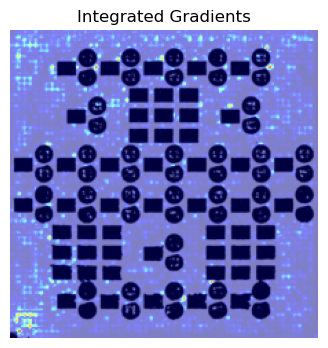

Top tabular contributors:
• ventilator_speed: 0.0067
• layer_times: 0.0035
• Layer Number: 0.0032
• top_flow_rate: 0.0019
• build_chamber_position: 0.0018


In [16]:
# ---------- Integrated-Gradients explanation (Captum) ----------
# pip install captum  (run once)

from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

# 1) target class index
target_idx = 0 if label.startswith("Powder") else 1

# 2) make tensors require grad
x_img = tensor_img.clone().detach().requires_grad_(True)
x_vec = torch.tensor(
    scaler.transform(params.values.reshape(1, -1)),
    dtype=torch.float32, requires_grad=True)

# 3) wrapper so Captum sees (img, vec) → logits
def fwd(img, vec):
    return model(img, vec)

ig = IntegratedGradients(fwd)

attr_img, attr_vec = ig.attribute(
    (x_img, x_vec),
    target=target_idx,
    return_convergence_delta=False)

# 4) build heat-map overlay
attr = attr_img.squeeze().detach().numpy()        # C,H,W
attr = np.mean(np.abs(attr), axis=0)              # H,W
attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

rgb  = np.transpose(x_img.squeeze().detach().numpy(), (1,2,0))
heat = plt.cm.jet(attr)[..., :3]                  # color-map
overlay = 0.5*rgb + 0.5*heat

plt.figure(figsize=(4,4))
plt.imshow(overlay); plt.axis("off"); plt.title("Integrated Gradients")
plt.show()

# 5) top contributing process parameters
names = params.index.tolist()
scores = np.abs(attr_vec.squeeze().detach().numpy())
top = sorted(zip(names, scores), key=lambda x: x[1], reverse=True)[:5]

print("Top tabular contributors:")
for n, s in top:
    print(f"• {n}: {s:.4f}")


In [21]:
# inside the same conda / venv you run the notebook
!pip install grad-cam



Exception ignored in: <function BaseCAM.__del__ at 0x000002B59EC40B80>
Traceback (most recent call last):
  File "c:\Users\ahsan\anaconda3\envs\vlm_3dprint\lib\site-packages\pytorch_grad_cam\base_cam.py", line 212, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Prediction: **Powder (empty bed)** — 100.0% confidence.
Top-chamber T = 26 °C, Bottom flow = 40.0 %, Ventilator = 35 rpm, O₂ = 0.0 ppm.
🔧 Increase bottom-flow > 45 %. 🔧 Boost ventilator > 40 rpm.
Grad-CAM skipped: GradCAM.__init__() got an unexpected keyword argument 'device'


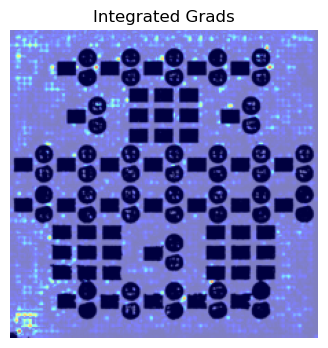

Top tabular contributors:
• ventilator_speed: 0.0067
• layer_times: 0.0035
• Layer Number: 0.0032
• top_flow_rate: 0.0019
• build_chamber_position: 0.0018


In [22]:
# ------------------------------------------------------------
# SMALL-VLM SINGLE-CELL INFERENCE + VISUAL + TABULAR EXPLANATION
# ------------------------------------------------------------
import os, re, warnings, torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

# ── silence torch.load pickle warning ───────────────────────
warnings.filterwarnings("ignore", category=FutureWarning,
                        message="You are using `torch.load`")

# ── paths (edit TEST_IMG as desired) ───────────────────────
CKPT_PATH = "small_vlm_defect.pt"
CSV_PATH  = "param_df_cleaned.csv"
TEST_IMG  = r"C:\Users\ahsan\Ahsan\Perigreen_paper\dataset\experiment1\classification\0\0_slice_5.png"

# ── load checkpoint, scaler, DataFrame ─────────────────────
ckpt    = torch.load(CKPT_PATH, map_location="cpu")
scaler  = ckpt["scaler"]
param_df = pd.read_csv(CSV_PATH).reset_index(drop=True)

# ── model definition (MUST keep 'classifier' name) ─────────
class SmallVLM(nn.Module):
    def __init__(self, n_params):
        super().__init__()
        base = models.resnet18(weights="IMAGENET1K_V1")
        base.fc = nn.Identity()          # 512-d output
        self.cnn = base
        self.mlp = nn.Sequential(nn.Linear(n_params,64), nn.ReLU(),
                                 nn.Linear(64,32))
        self.classifier = nn.Sequential(   # keep this name!
            nn.Linear(512+32,64), nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self, img, vec):
        return self.classifier(
            torch.cat((self.cnn(img), self.mlp(vec)), dim=1)
        )

model = SmallVLM(n_params=scaler.mean_.shape[0])
model.load_state_dict(ckpt["model_state"]); model.eval()

# ── helpers ─────────────────────────────────────────────────
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
layer_re  = re.compile(r"^(\d+)_")
label_map = {0:"Powder (empty bed)", 1:"Printed region (healthy)"}

def predict_one(img_path:str):
    img_pil = Image.open(img_path).convert("RGB")
    x_img   = transform(img_pil).unsqueeze(0)
    m = layer_re.match(os.path.basename(img_path))
    if not m: raise ValueError("Filename must start with layer number + '_'")
    layer   = int(m.group(1))
    row_raw = param_df.loc[layer]
    x_vec   = torch.tensor(scaler.transform(row_raw.values.reshape(1,-1)),
                           dtype=torch.float32)
    with torch.no_grad():
        prob = F.softmax(model(x_img, x_vec),1)
        conf, idx = prob.max(1)
    return label_map[idx.item()], conf.item()*100, row_raw, img_pil, x_img

def context_sentence(lbl, conf, row):
    return (f"Prediction: **{lbl}** — {conf:.1f}% confidence.\n"
            f"Top-chamber T = {row['top_chamber_temperature']:.0f} °C, "
            f"Bottom flow = {row['bottom_flow_rate']:.1f} %, "
            f"Ventilator = {row['ventilator_speed']:.0f} rpm, "
            f"O₂ = {row['gas_loop_oxygen']:.1f} ppm.")

def suggestion(row):
    tips=[]
    if row['bottom_flow_rate']<45: tips.append("🔧 Increase bottom-flow > 45 %.")
    if row['ventilator_speed']<40: tips.append("🔧 Boost ventilator > 40 rpm.")
    if row['gas_loop_oxygen']>10:  tips.append("🔧 Purge chamber (O₂ < 10 ppm).")
    return " ".join(tips) if tips else "✅ Parameters within nominal range."

# ── run prediction ──────────────────────────────────────────
label, conf, params, pil_img, tensor_img = predict_one(TEST_IMG)
print(context_sentence(label, conf, params))
print(suggestion(params))

# ── Grad-CAM (if library available) ────────────────────────
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    target_layer = model.cnn.layer4[-1]
    cam = GradCAM(model, [target_layer], device="cpu")
    heat = cam(tensor_img,
               extra_forward_args=(torch.tensor(
                   scaler.transform(params.values.reshape(1,-1)),
                   dtype=torch.float32),))[0]
    rgb  = np.transpose(tensor_img.squeeze().numpy(), (1,2,0))
    cam_img = show_cam_on_image(rgb, heat, use_rgb=True)
    plt.figure(figsize=(4,4)); plt.imshow(cam_img); plt.axis("off"); plt.title("Grad-CAM"); plt.show()
except Exception as e:
    print("Grad-CAM skipped:", e)

# ── Integrated-Gradients (if captum installed) ─────────────
try:
    from captum.attr import IntegratedGradients
    ig = IntegratedGradients(lambda img,vec: model(img,vec))
    x_img = tensor_img.clone().detach().requires_grad_(True)
    x_vec = torch.tensor(scaler.transform(params.values.reshape(1,-1)),
                         dtype=torch.float32, requires_grad=True)
    tgt   = 0 if label.startswith("Powder") else 1
    attr_img, attr_vec = ig.attribute((x_img, x_vec), target=tgt)
    a = np.mean(np.abs(attr_img.squeeze().detach().numpy()),0)
    a = (a-a.min())/(a.max()-a.min()+1e-8)
    overlay = 0.5*rgb + 0.5*plt.cm.jet(a)[...,:3]
    plt.figure(figsize=(4,4)); plt.imshow(overlay); plt.axis("off"); plt.title("Integrated Grads"); plt.show()

    scores = np.abs(attr_vec.squeeze().detach().numpy())
    top = sorted(zip(params.index, scores), key=lambda x: x[1], reverse=True)[:5]
    print("Top tabular contributors:")
    for n,s in top: print(f"• {n}: {s:.4f}")
except Exception as e:
    print("Integrated-Gradients skipped:", e)


Prediction: **Powder (empty bed)** — 100.0% confidence.
Top-chamber T = 26 °C, Bottom flow = 40.0 %, Ventilator = 35 rpm, O₂ = 0.0 ppm.
🔧 Increase bottom-flow > 45 %. 🔧 Boost ventilator > 40 rpm.


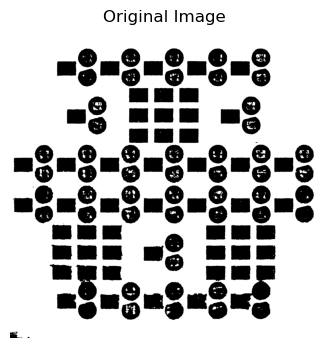

Exception ignored in: <function BaseCAM.__del__ at 0x000002B59EC40B80>
Traceback (most recent call last):
  File "c:\Users\ahsan\anaconda3\envs\vlm_3dprint\lib\site-packages\pytorch_grad_cam\base_cam.py", line 212, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Grad-CAM skipped: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'


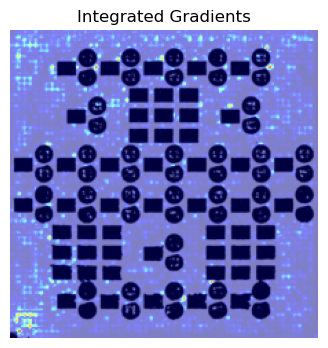

Top tabular contributors:
• ventilator_speed: 0.0067
• layer_times: 0.0035
• Layer Number: 0.0032
• top_flow_rate: 0.0019
• build_chamber_position: 0.0018


In [23]:
# ------------------------------------------------------------
# SMALL-VLM SINGLE-CELL INFERENCE + VISUAL + TABULAR EXPLANATION
# ------------------------------------------------------------
import os, re, warnings, torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load`")

# Paths (edit TEST_IMG)
CKPT_PATH = "small_vlm_defect.pt"
CSV_PATH  = "param_df_cleaned.csv"
TEST_IMG  = r"C:\Users\ahsan\Ahsan\Perigreen_paper\dataset\experiment1\classification\0\0_slice_5.png"

# Load checkpoint, scaler, param DataFrame
ckpt    = torch.load(CKPT_PATH, map_location="cpu")
scaler  = ckpt["scaler"]
param_df = pd.read_csv(CSV_PATH).reset_index(drop=True)

# Model definition
class SmallVLM(nn.Module):
    def __init__(self, n_params):
        super().__init__()
        base = models.resnet18(weights="IMAGENET1K_V1")
        base.fc = nn.Identity()
        self.cnn = base
        self.mlp = nn.Sequential(nn.Linear(n_params,64), nn.ReLU(), nn.Linear(64,32))
        self.classifier = nn.Sequential(nn.Linear(512+32,64), nn.ReLU(), nn.Linear(64,2))
    def forward(self, img, vec):
        return self.classifier(torch.cat((self.cnn(img), self.mlp(vec)), dim=1))

model = SmallVLM(n_params=scaler.mean_.shape[0])
model.load_state_dict(ckpt["model_state"]); model.eval()

# Utilities
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
layer_re  = re.compile(r"^(\d+)_")
label_map = {0:"Powder (empty bed)", 1:"Printed region (healthy)"}

def predict_one(img_path:str):
    img_pil = Image.open(img_path).convert("RGB")
    x_img   = transform(img_pil).unsqueeze(0)
    m = layer_re.match(os.path.basename(img_path))
    if not m: raise ValueError("Filename must start with layer number + '_'")
    layer   = int(m.group(1))
    row_raw = param_df.loc[layer]
    x_vec   = torch.tensor(scaler.transform(row_raw.values.reshape(1,-1)),
                           dtype=torch.float32)
    with torch.no_grad():
        prob = F.softmax(model(x_img, x_vec),1)
        conf, idx = prob.max(1)
    return label_map[idx.item()], conf.item()*100, row_raw, img_pil, x_img

def context_sentence(lbl, conf, row):
    return (f"Prediction: **{lbl}** — {conf:.1f}% confidence.\n"
            f"Top-chamber T = {row['top_chamber_temperature']:.0f} °C, "
            f"Bottom flow = {row['bottom_flow_rate']:.1f} %, "
            f"Ventilator = {row['ventilator_speed']:.0f} rpm, "
            f"O₂ = {row['gas_loop_oxygen']:.1f} ppm.")

def suggestion(row):
    tips=[]
    if row['bottom_flow_rate']<45: tips.append("🔧 Increase bottom-flow > 45 %.")    
    if row['ventilator_speed']<40: tips.append("🔧 Boost ventilator > 40 rpm.")
    if row['gas_loop_oxygen']>10:  tips.append("🔧 Purge chamber (O₂ < 10 ppm).")
    return " ".join(tips) if tips else "✅ Parameters within nominal range."

# Run prediction
label, conf, params, pil_img, tensor_img = predict_one(TEST_IMG)
print(context_sentence(label, conf, params))
print(suggestion(params))

# Show original image
plt.figure(figsize=(4,4))
plt.imshow(pil_img)
plt.axis("off")
plt.title("Original Image")
plt.show()

# Grad-CAM
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    target_layer = model.cnn.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=False)
    cam_result = cam(input_tensor=tensor_img,
                     extra_forward_args=(torch.tensor(
                         scaler.transform(params.values.reshape(1,-1)),
                         dtype=torch.float32),))[0]
    rgb = np.transpose(tensor_img.squeeze().numpy(), (1,2,0))
    cam_img = show_cam_on_image(rgb, cam_result, use_rgb=True)
    plt.figure(figsize=(4,4)); plt.imshow(cam_img); plt.axis("off"); plt.title("Grad-CAM"); plt.show()
except Exception as e:
    print("Grad-CAM skipped:", e)

# Integrated Gradients
try:
    from captum.attr import IntegratedGradients
    ig = IntegratedGradients(lambda img,vec: model(img,vec))
    x_img = tensor_img.clone().detach().requires_grad_(True)
    x_vec = torch.tensor(scaler.transform(params.values.reshape(1,-1)),
                         dtype=torch.float32, requires_grad=True)
    tgt   = 0 if label.startswith("Powder") else 1
    attr_img, attr_vec = ig.attribute((x_img, x_vec), target=tgt)
    a = np.mean(np.abs(attr_img.squeeze().detach().numpy()),0)
    a = (a-a.min())/(a.max()-a.min()+1e-8)
    overlay = 0.5*rgb + 0.5*plt.cm.jet(a)[...,:3]
    plt.figure(figsize=(4,4)); plt.imshow(overlay); plt.axis("off"); plt.title("Integrated Gradients"); plt.show()

    scores = np.abs(attr_vec.squeeze().detach().numpy())
    top = sorted(zip(params.index, scores), key=lambda x: x[1], reverse=True)[:5]
    print("Top tabular contributors:")
    for n,s in top: print(f"• {n}: {s:.4f}")
except Exception as e:
    print("Integrated-Gradients skipped:", e)


In [24]:
# -----------------------------------------------------------------
# 1.  Imports
# -----------------------------------------------------------------
import numpy as np, torch
from lime import lime_tabular
from IPython.display import display
# (make sure SmallVLM, model, scaler, transform etc. are already defined)

# -----------------------------------------------------------------
# 2.  Helper: prediction function for LIME
# -----------------------------------------------------------------
def predict_lime(temporal_np: np.ndarray):
    """
    temporal_np : shape (n_samples, n_features) – raw, unscaled values
    Returns     : shape (n_samples, 2) – [p_class0, p_class1]
    """
    # 2.1 scale with the SAME StandardScaler used in training
    X_scaled = scaler.transform(temporal_np).astype("float32")
    x_vec = torch.tensor(X_scaled)
    
    # 2.2 create dummy images (all-black) to keep the image branch neutral
    n = temporal_np.shape[0]
    dummy_imgs = torch.zeros((n, 3, 224, 224))   # BCHW, already 0-to-1
    
    # 2.3 forward pass
    with torch.no_grad():
        logits = model(dummy_imgs, x_vec)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
    return probs   # shape (n, 2)

# -----------------------------------------------------------------
# 3.  Prepare data for the explainer
# -----------------------------------------------------------------
feature_names = list(param_df.columns)          # all 20 names
class_names   = ["Powder", "Printed"]

# `train_temporal` is simply param_df values (unscaled) for reference
train_temporal = param_df.values

explainer = lime_tabular.LimeTabularExplainer(
    training_data            = train_temporal,
    mode                     = "classification",
    feature_names            = feature_names,
    class_names              = class_names,
    discretize_continuous    = True
)

# -----------------------------------------------------------------
# 4.  Choose one slice and explain
# -----------------------------------------------------------------
layer_idx = 5                                 # pick any layer number
temporal_row = param_df.loc[layer_idx].values

explanation = explainer.explain_instance(
    data_row      = temporal_row,
    predict_fn    = predict_lime,
    num_features  = 8,        # top k features to display
    num_samples   = 1000      # LIME perturbation samples
)

# -----------------------------------------------------------------
# 5.  Visualise (in Jupyter)
# -----------------------------------------------------------------
display(explanation.show_in_notebook(show_table=True, show_all=False))
# -----------------------------------------------------------------
#  (In Streamlit you would do: st.components.v1.html(explanation.as_html(), height=400))


None

In [25]:
# ---------- helper functions (copy once) -------------------
def build_context(label: str, conf: float, row) -> str:
    """
    Human-readable summary of prediction + key process parameters.
    """
    return (
        f"### 🧠 Prediction\n"
        f"**{label}** &nbsp;|&nbsp; **Confidence:** {conf:.1f}%  \n\n"
        f"**Top-chamber T:** {row['top_chamber_temperature']:.0f} °C  \n"
        f"**Bottom flow rate:** {row['bottom_flow_rate']:.1f}%  \n"
        f"**Ventilator speed:** {row['ventilator_speed']:.0f} rpm  \n"
        f"**O₂ level:** {row['gas_loop_oxygen']:.1f} ppm"
    )

def build_suggestion(row) -> str:
    """
    Rule-based recommendation string.
    """
    tips = []
    if row['bottom_flow_rate'] < 45:
        tips.append("🔧 *Increase bottom-flow rate above **45 %**.*")
    if row['ventilator_speed'] < 40:
        tips.append("🔧 *Boost ventilator speed above **40 rpm**.*")
    if row['gas_loop_oxygen'] > 10:
        tips.append("🔧 *Purge chamber to keep O₂ below **10 ppm**.*")
    return "### 💡 Suggestions\n" + ("\n\n".join(tips) if tips else "✅ All parameters within nominal range.")

# ---------- run on one image --------------------------------
label, conf, params, pil_img, tensor_img = predict_one(TEST_IMG)

# • In a notebook:
from IPython.display import display, Markdown
display(Markdown(build_context(label, conf, params)))
display(Markdown(build_suggestion(params)))

# • In Streamlit:
# st.markdown(build_context(label, conf, params))
# st.markdown(build_suggestion(params))


### 🧠 Prediction
**Powder (empty bed)** &nbsp;|&nbsp; **Confidence:** 100.0%  

**Top-chamber T:** 26 °C  
**Bottom flow rate:** 40.0%  
**Ventilator speed:** 35 rpm  
**O₂ level:** 0.0 ppm

### 💡 Suggestions
🔧 *Increase bottom-flow rate above **45 %**.*

🔧 *Boost ventilator speed above **40 rpm**.*